<a href="https://colab.research.google.com/github/Senuth-Per/Six-by-six-maze/blob/main/AI_6_6_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start Node: 7 at (1, 1)
Goal Node: 35 at (5, 5)
Barrier Nodes: [15, 3, 20, 30]


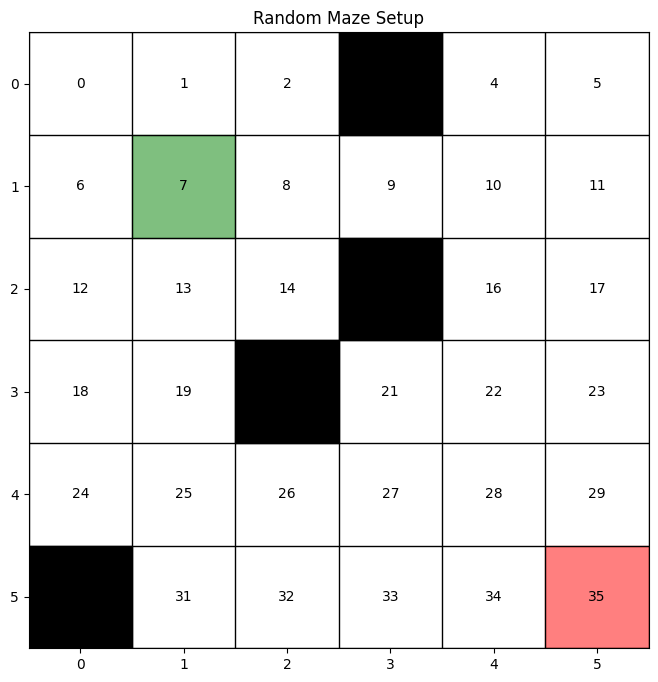

In [ ]:
# Task 01

# Import necessary libraries
import numpy as np              # For numerical operations and calculations
import heapq                    # For priority queue implementation used in search algorithms
import time                     # For timing operations
import matplotlib.pyplot as plt # For visualization of the maze and paths
import random                   # For generating random maze configurations
from IPython.display import display, clear_output  # For display control in Colab
import pandas as pd             # For data analysis and table creation

# Try to import tabulate for pretty tables, install if not available
try:
    import tabulate            # For formatting nice tables in output
except ImportError:
    !pip install tabulate      # Install the package if not found
    import tabulate            # Import after installation

class MazeNode:
    """A node in the maze with coordinates, state, and search properties."""
    def __init__(self, x, y, node_id):
        self.x = x              # X-coordinate of the node in the maze
        self.y = y              # Y-coordinate of the node in the maze
        self.node_id = node_id  # Unique identifier for the node (0-35)
        self.is_barrier = False # Flag indicating if node is a barrier
        self.is_start = False   # Flag indicating if node is the start point
        self.is_goal = False    # Flag indicating if node is the goal point

    def __str__(self):
        # String representation of node for printing
        if self.is_barrier:
            return "B"          # Display 'B' for barrier nodes
        elif self.is_start:
            return "S"          # Display 'S' for start node
        elif self.is_goal:
            return "G"          # Display 'G' for goal node
        else:
            return str(self.node_id)  # Display node ID for regular nodes

    def __lt__(self, other):
        # Comparison method required for priority queue operations
        # Sorts nodes by their node_id when comparing
        return self.node_id < other.node_id

class Maze:
    """Represents a 6x6 maze with barriers, start and goal nodes."""
    def __init__(self):
        self.size = 6           # Size of the maze (6x6)
        self.nodes = {}         # Dictionary to store all nodes, key is (x,y) coordinate
        self.start_node = None  # Reference to the start node
        self.goal_node = None   # Reference to the goal node
        self.barriers = []      # List to store barrier nodes

        # Initialize nodes - create all 36 nodes with their coordinates and IDs
        node_id = 0
        for y in range(self.size):
            for x in range(self.size):
                # Create a node for each position in the grid
                self.nodes[(x, y)] = MazeNode(x, y, node_id)
                node_id += 1     # Increment node ID for next node

    def setup_random_maze(self):
        """Randomly set start, goal, and barrier nodes according to specifications."""
        # Reset any previous setup - clear all node flags
        for node in self.nodes.values():
            node.is_barrier = False
            node.is_start = False
            node.is_goal = False

        # Select random start node (0-11) as specified in requirements
        start_id = random.randint(0, 11)
        # Convert node ID to x,y coordinates
        start_x, start_y = start_id % self.size, start_id // self.size
        self.start_node = self.nodes[(start_x, start_y)]
        self.start_node.is_start = True  # Mark as start node

        # Select random goal node (24-35) as specified in requirements
        goal_id = random.randint(24, 35)
        # Convert node ID to x,y coordinates
        goal_x, goal_y = goal_id % self.size, goal_id // self.size
        self.goal_node = self.nodes[(goal_x, goal_y)]
        self.goal_node.is_goal = True    # Mark as goal node

        # Select 4 random barrier nodes from remaining nodes
        # First, get all nodes that are not start or goal
        available_nodes = [node for node in self.nodes.values()
                           if not node.is_start and not node.is_goal]
        # Randomly select 4 nodes to be barriers
        barrier_nodes = random.sample(available_nodes, 4)

        self.barriers = []  # Reset barriers list
        for node in barrier_nodes:
            node.is_barrier = True  # Mark as barrier
            self.barriers.append(node)  # Add to barriers list

        # Return references to important nodes for convenience
        return self.start_node, self.goal_node, self.barriers

    def get_neighbors(self, node):
        """Get all valid neighbors of a node (horizontal, vertical, diagonal)."""
        neighbors = []  # List to store valid neighbor nodes
        x, y = node.x, node.y  # Current node coordinates

        # Check all 8 directions (horizontal, vertical, diagonal)
        for dx in [-1, 0, 1]:  # Change in x-coordinate (-1: left, 0: same, 1: right)
            for dy in [-1, 0, 1]:  # Change in y-coordinate (-1: up, 0: same, 1: down)
                if dx == 0 and dy == 0:
                    continue  # Skip the node itself (no change in coordinates)

                # Calculate new coordinates
                nx, ny = x + dx, y + dy
                # Check if new coordinates are within maze boundaries
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    neighbor = self.nodes[(nx, ny)]
                    # Only add neighbor if it's not a barrier
                    if not neighbor.is_barrier:
                        neighbors.append(neighbor)

        # Sort neighbors by node ID to process in increasing order (requirement)
        neighbors.sort(key=lambda n: n.node_id)
        return neighbors

    def edge_cost(self, node1, node2):
        """Calculate edge cost based on node positions."""
        # Calculate the absolute difference in coordinates
        dx = abs(node1.x - node2.x)
        dy = abs(node1.y - node2.y)

        # Diagonal movement costs sqrt(2) ≈ 1.414 (Euclidean distance)
        if dx == 1 and dy == 1:
            return 1.414  # Cost for diagonal movement
        # Horizontal or vertical movement costs 1
        else:
            return 1.0    # Cost for horizontal/vertical movement

    def visualize(self, visited=None, path=None, title="Maze"):
        """Visualize the maze with matplotlib."""
        # Create figure and axes with appropriate size
        fig, ax = plt.subplots(figsize=(8, 8))

        # Create grid lines
        for i in range(self.size + 1):
            ax.axhline(i, color='black', linewidth=1)  # Horizontal lines
            ax.axvline(i, color='black', linewidth=1)  # Vertical lines

        # Color the cells based on their type and state
        for (x, y), node in self.nodes.items():
            if node.is_barrier:
                # Black rectangle for barrier nodes
                ax.add_patch(plt.Rectangle((x, self.size - y - 1), 1, 1, color='black'))
            elif node.is_start:
                # Green rectangle for start node
                ax.add_patch(plt.Rectangle((x, self.size - y - 1), 1, 1, color='green', alpha=0.5))
            elif node.is_goal:
                # Red rectangle for goal node
                ax.add_patch(plt.Rectangle((x, self.size - y - 1), 1, 1, color='red', alpha=0.5))
            elif visited and node in visited and not (node in path if path else False):
                # Yellow rectangle for visited nodes that are not part of the final path
                ax.add_patch(plt.Rectangle((x, self.size - y - 1), 1, 1, color='yellow', alpha=0.3))

            # Add node ID text to each cell
            plt.text(x + 0.5, self.size - y - 0.5, str(node.node_id),
                     ha='center', va='center', fontsize=10)

        # Draw path if provided
        if path:
            # Extract x and y coordinates for the path
            path_x = [node.x + 0.5 for node in path]  # Center of each cell (x)
            path_y = [self.size - node.y - 0.5 for node in path]  # Center of each cell (y)
            # Draw blue line connecting path nodes
            ax.plot(path_x, path_y, 'b-', linewidth=2)

            # Highlight path nodes with light blue color
            for node in path:
                if not (node.is_start or node.is_goal):  # Don't highlight start/goal nodes
                    ax.add_patch(plt.Rectangle((node.x, self.size - node.y - 1), 1, 1, color='lightblue', alpha=0.5))

        # Set title and adjust display settings
        ax.set_title(title)
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        # Set tick positions and labels
        ax.set_xticks([x + 0.5 for x in range(self.size)])
        ax.set_xticklabels(range(self.size))
        ax.set_yticks([y + 0.5 for y in range(self.size)])
        ax.set_yticklabels(range(self.size-1, -1, -1))  # Reverse y-axis labels

        # Display the plot
        plt.show()

# Create and display a sample maze when running this script directly
if __name__ == "__main__":
    # Create a new maze object
    maze = Maze()
    # Set up random start, goal, and barriers
    start, goal, barriers = maze.setup_random_maze()

    # Print maze configuration information
    print(f"Start Node: {start.node_id} at ({start.x}, {start.y})")
    print(f"Goal Node: {goal.node_id} at ({goal.x}, {goal.y})")
    print(f"Barrier Nodes: {[b.node_id for b in barriers]}")

    # Visualize the maze
    maze.visualize(title="Random Maze Setup")

***Colors and what they mean***


*   Green - Start Node
*   Red - Goal Node
*   Black - Barrier Nodes
*   Yellow - Visited nodes



Start Node: 3 at (3, 0)
Goal Node: 29 at (5, 4)
Barrier Nodes: [10, 6, 30, 2]

Running Uniform Cost Search...
UCS Path Found! Time: 26 minutes
Visited Nodes (26): [3, 4, 9, 8, 5, 15, 7, 11, 14, 16, 1, 13, 21, 17, 20, 22, 0, 12, 19, 23, 27, 18, 26, 28, 25, 29]
Path (5): [3, 9, 15, 22, 29]


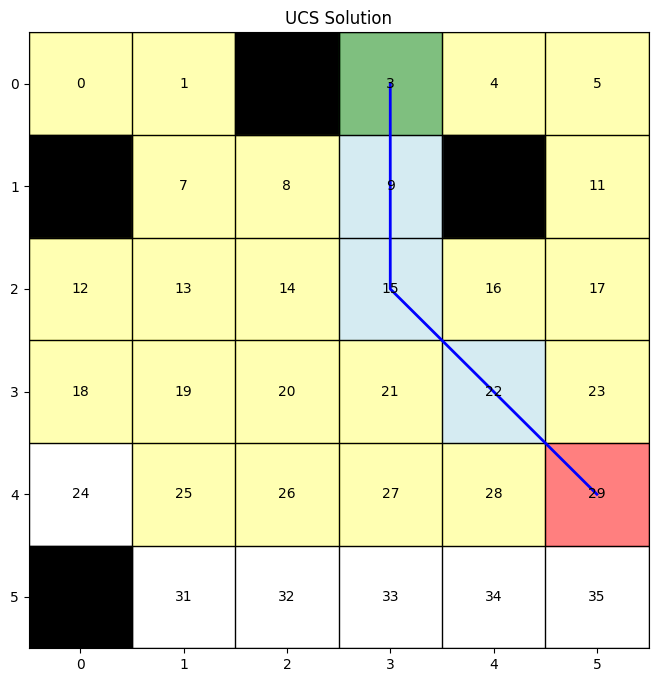

In [ ]:
# Task 02

def uniform_cost_search(maze):
    """
    Implements Uniform Cost Search algorithm to find the shortest path.
    Returns visited nodes list, time to find goal, and final path.
    """
    # Initialize data structures
    start = maze.start_node  # Get the starting node
    goal = maze.goal_node    # Get the goal node

    # Priority queue for frontier: (cost, node, path)
    # The heapq module will prioritize by the first element (cost)
    frontier = [(0, start, [start])]  # Initial state: 0 cost, start node, path only contains start

    # Set for tracking visited nodes (for efficiency)
    visited = set()

    # List to keep track of visited nodes in order of expansion
    visited_list = []

    # Statistics counter for analysis
    nodes_explored = 0

    # Main loop - continue until frontier is empty or goal is found
    while frontier:
        # Get node with lowest cost from frontier (priority queue)
        current_cost, current_node, current_path = heapq.heappop(frontier)

        # Skip if this node was already visited (we already found a better path)
        if current_node in visited:
            continue

        # Mark current node as visited
        visited.add(current_node)
        visited_list.append(current_node)  # Record visit order
        nodes_explored += 1  # Increment exploration counter

        # Check if goal is reached
        if current_node == goal:
            # Time to find goal is the sum of all nodes explored (1 minute per node as specified)
            time_to_goal = nodes_explored
            return visited_list, time_to_goal, current_path

        # Get neighbors of current node
        neighbors = maze.get_neighbors(current_node)

        # Process neighbors in increasing order of node ID (already sorted by get_neighbors)
        for neighbor in neighbors:
            # Only process unvisited neighbors
            if neighbor not in visited:
                # Calculate new cost by adding edge cost to current cost
                new_cost = current_cost + maze.edge_cost(current_node, neighbor)

                # Create new path by appending neighbor to current path
                new_path = current_path + [neighbor]

                # Add to frontier with updated cost and path
                heapq.heappush(frontier, (new_cost, neighbor, new_path))

    # If no path is found (frontier emptied without reaching goal)
    return visited_list, nodes_explored, None

# Test UCS on a sample maze when running this script directly
if __name__ == "__main__":
    # Create and setup maze
    maze = Maze()
    start, goal, barriers = maze.setup_random_maze()

    # Print maze configuration
    print(f"Start Node: {start.node_id} at ({start.x}, {start.y})")
    print(f"Goal Node: {goal.node_id} at ({goal.x}, {goal.y})")
    print(f"Barrier Nodes: {[b.node_id for b in barriers]}")

    # Run Uniform Cost Search algorithm
    print("\nRunning Uniform Cost Search...")
    ucs_visited, ucs_time, ucs_path = uniform_cost_search(maze)

    # Check if a path was found
    if ucs_path:
        # Print search results
        print(f"UCS Path Found! Time: {ucs_time} minutes")
        print(f"Visited Nodes ({len(ucs_visited)}): {[n.node_id for n in ucs_visited]}")
        print(f"Path ({len(ucs_path)}): {[n.node_id for n in ucs_path]}")

        # Visualize results
        maze.visualize(ucs_visited, ucs_path, "UCS Solution")
    else:
        print("UCS: No path found!")

In [ ]:
# Task 03

def chebyshev_distance(self, node, goal):
    """
    Calculate the Chebyshev distance between node and goal.
    Chebyshev distance is defined as: d(N,G) = max(|Nx–Gx|, |Ny–Gy|)
    This represents the maximum of the absolute differences in x and y coordinates.
    """
    # Calculate absolute differences in coordinates
    x_diff = abs(node.x - goal.x)  # Absolute difference in x coordinates
    y_diff = abs(node.y - goal.y)  # Absolute difference in y coordinates

    # Return the maximum of the two differences
    return max(x_diff, y_diff)

# Add the method to the Maze class if not already there
# This makes the function available as a method of the Maze class
Maze.chebyshev_distance = chebyshev_distance

# Test the heuristic function when running this script directly
if __name__ == "__main__":
    # Create and setup maze
    maze = Maze()
    start, goal, barriers = maze.setup_random_maze()

    # Print maze configuration
    print(f"Start Node: {start.node_id} at ({start.x}, {start.y})")
    print(f"Goal Node: {goal.node_id} at ({goal.x}, {goal.y})")

    # Calculate and display heuristic for each node to the goal
    print("\nChebyshev Distance from each node to goal:")
    for node in maze.nodes.values():
        # Calculate heuristic value for this node
        h = maze.chebyshev_distance(node, goal)
        # Print node information and its heuristic value
        print(f"Node {node.node_id} at ({node.x}, {node.y}) to Goal: {h}")

Start Node: 5 at (5, 0)
Goal Node: 34 at (4, 5)

Chebyshev Distance from each node to goal:
Node 0 at (0, 0) to Goal: 5
Node 1 at (1, 0) to Goal: 5
Node 2 at (2, 0) to Goal: 5
Node 3 at (3, 0) to Goal: 5
Node 4 at (4, 0) to Goal: 5
Node 5 at (5, 0) to Goal: 5
Node 6 at (0, 1) to Goal: 4
Node 7 at (1, 1) to Goal: 4
Node 8 at (2, 1) to Goal: 4
Node 9 at (3, 1) to Goal: 4
Node 10 at (4, 1) to Goal: 4
Node 11 at (5, 1) to Goal: 4
Node 12 at (0, 2) to Goal: 4
Node 13 at (1, 2) to Goal: 3
Node 14 at (2, 2) to Goal: 3
Node 15 at (3, 2) to Goal: 3
Node 16 at (4, 2) to Goal: 3
Node 17 at (5, 2) to Goal: 3
Node 18 at (0, 3) to Goal: 4
Node 19 at (1, 3) to Goal: 3
Node 20 at (2, 3) to Goal: 2
Node 21 at (3, 3) to Goal: 2
Node 22 at (4, 3) to Goal: 2
Node 23 at (5, 3) to Goal: 2
Node 24 at (0, 4) to Goal: 4
Node 25 at (1, 4) to Goal: 3
Node 26 at (2, 4) to Goal: 2
Node 27 at (3, 4) to Goal: 1
Node 28 at (4, 4) to Goal: 1
Node 29 at (5, 4) to Goal: 1
Node 30 at (0, 5) to Goal: 4
Node 31 at (1, 5) t

Start Node: 8 at (2, 1)
Goal Node: 29 at (5, 4)
Barrier Nodes: [7, 4, 35, 1]

Running A* Search...
A* Path Found! Time: 6 minutes
Visited Nodes (6): [8, 15, 22, 9, 14, 29]
Path (4): [8, 15, 22, 29]


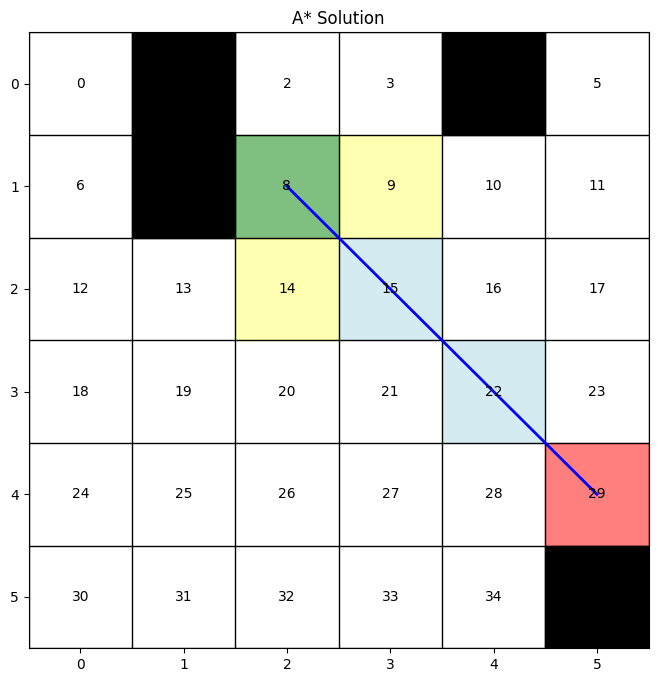

In [ ]:
# Task 04

def a_star_search(maze):
    """
    Implements A* Search algorithm to find the shortest path.
    Uses Chebyshev distance as the heuristic function.
    Returns visited nodes list, time to find goal, and final path.
    """
    # Initialize data structures
    start = maze.start_node  # Get the starting node
    goal = maze.goal_node    # Get the goal node

    # Priority queue for frontier: (f_cost, node_id, g_cost, node, path)
    # f_cost = g_cost + h_cost (total estimated cost)
    # node_id is used as a tiebreaker when f_costs are equal
    # g_cost is the actual cost from start to this node
    frontier = [(maze.chebyshev_distance(start, goal), start.node_id, 0, start, [start])]

    # Dictionary to keep track of best g_cost (actual cost) to each node
    g_costs = {start: 0}

    # Set for tracking visited nodes
    visited = set()

    # List to keep track of visited nodes in order of expansion
    visited_list = []

    # Statistics counter for analysis
    nodes_explored = 0

    # Main loop - continue until frontier is empty or goal is found
    while frontier:
        # Get node with lowest f_cost from frontier
        f_cost, _, g_cost, current_node, current_path = heapq.heappop(frontier)

        # Skip if we already found a better path to this node
        # This is different from UCS - we check g_cost too
        if current_node in visited and g_cost >= g_costs[current_node]:
            continue

        # Mark current node as visited
        visited.add(current_node)
        visited_list.append(current_node)  # Record visit order
        nodes_explored += 1  # Increment exploration counter

        # Check if goal is reached
        if current_node == goal:
            # Time to find goal is the sum of all nodes explored (1 minute per node)
            time_to_goal = nodes_explored
            return visited_list, time_to_goal, current_path

        # Get neighbors of current node
        neighbors = maze.get_neighbors(current_node)

        # Process neighbors in increasing order of node ID (already sorted)
        for neighbor in neighbors:
            # Calculate new g_cost (actual cost from start)
            new_g_cost = g_cost + maze.edge_cost(current_node, neighbor)

            # Skip if we already found a better path to this neighbor
            # This is A*'s optimization over UCS - checking g_cost
            if neighbor in g_costs and new_g_cost >= g_costs[neighbor]:
                continue

            # Update best known g_cost to this neighbor
            g_costs[neighbor] = new_g_cost

            # Calculate f_cost = g_cost + h_cost
            # h_cost is the heuristic estimate from neighbor to goal
            h_cost = maze.chebyshev_distance(neighbor, goal)
            f_cost = new_g_cost + h_cost

            # Create new path by appending neighbor to current path
            new_path = current_path + [neighbor]

            # Add to frontier with calculated costs
            heapq.heappush(frontier, (f_cost, neighbor.node_id, new_g_cost, neighbor, new_path))

    # If no path is found (frontier emptied without reaching goal)
    return visited_list, nodes_explored, None

# Test A* on a sample maze when running this script directly
if __name__ == "__main__":
    # Create and setup maze
    maze = Maze()
    start, goal, barriers = maze.setup_random_maze()

    # Print maze configuration
    print(f"Start Node: {start.node_id} at ({start.x}, {start.y})")
    print(f"Goal Node: {goal.node_id} at ({goal.x}, {goal.y})")
    print(f"Barrier Nodes: {[b.node_id for b in barriers]}")

    # Run A* Search algorithm
    print("\nRunning A* Search...")
    astar_visited, astar_time, astar_path = a_star_search(maze)

    # Check if a path was found
    if astar_path:
        # Print search results
        print(f"A* Path Found! Time: {astar_time} minutes")
        print(f"Visited Nodes ({len(astar_visited)}): {[n.node_id for n in astar_visited]}")
        print(f"Path ({len(astar_path)}): {[n.node_id for n in astar_path]}")

        # Visualize results
        maze.visualize(astar_visited, astar_path, "A* Solution")
    else:
        print("A*: No path found!")

Six-by-Six Maze Search Algorithms: UCS and A*

--- Maze 1 ---
Start Node: 9 at (3, 1)
Goal Node: 31 at (1, 5)
Barrier Nodes: [19, 13, 27, 3]


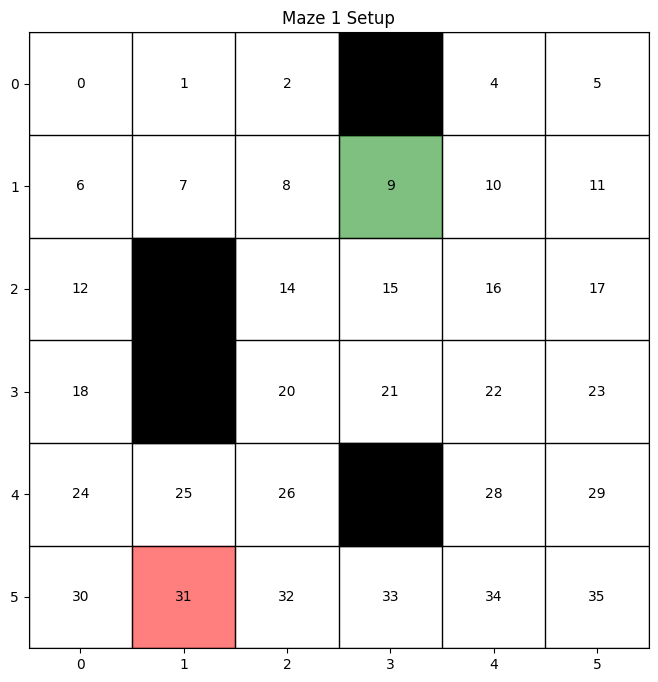


Running Uniform Cost Search...
UCS Path Found! Time: 29 minutes
Visited Nodes (29): [9, 8, 10, 15, 2, 4, 14, 16, 7, 11, 21, 1, 5, 17, 20, 22, 23, 6, 0, 12, 26, 28, 25, 29, 18, 32, 34, 24, 31]
Path (5): [9, 14, 20, 25, 31]


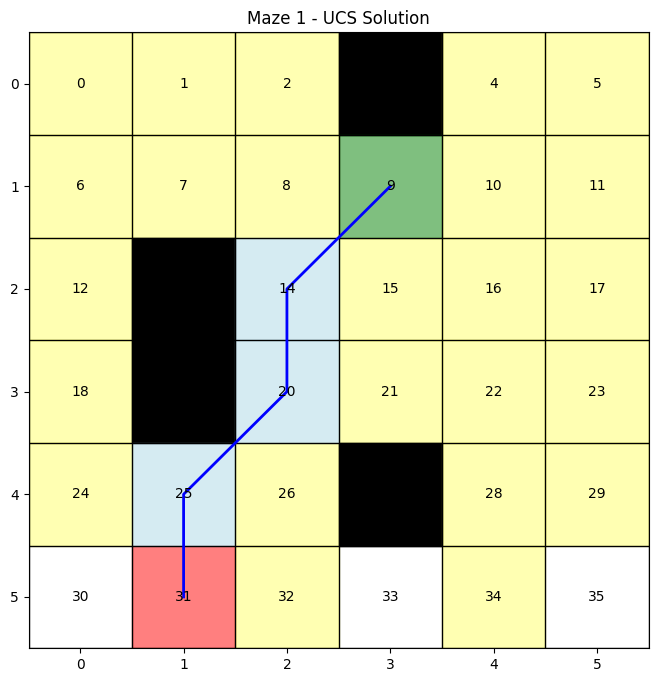


Running A* Search...
A* Path Found! Time: 9 minutes
Visited Nodes (9): [9, 15, 21, 14, 16, 20, 26, 25, 31]
Path (5): [9, 15, 21, 26, 31]


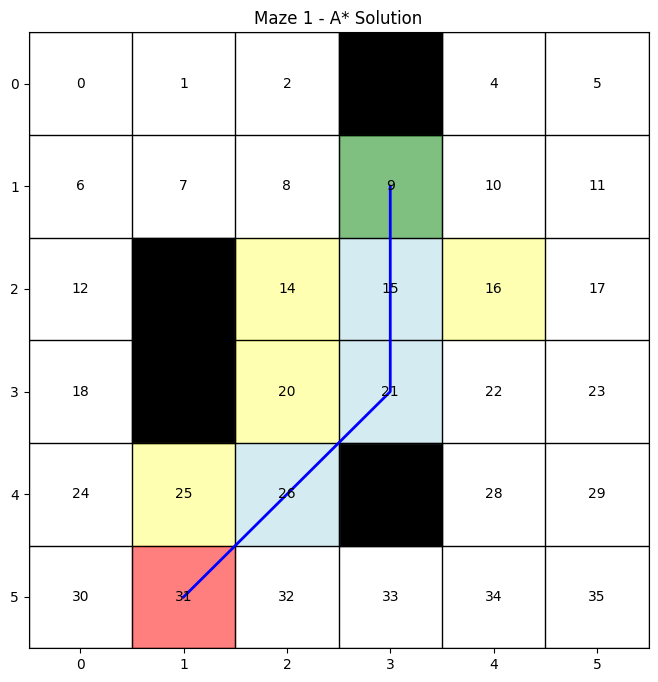


--- Maze 2 ---
Start Node: 8 at (2, 1)
Goal Node: 31 at (1, 5)
Barrier Nodes: [20, 25, 28, 7]


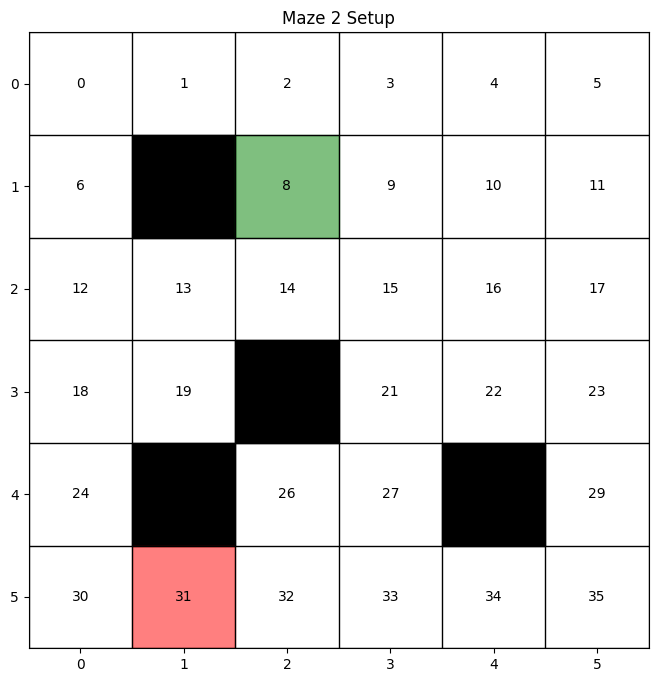


Running Uniform Cost Search...
UCS Path Found! Time: 31 minutes
Visited Nodes (31): [8, 2, 9, 14, 1, 3, 13, 15, 10, 0, 4, 12, 16, 19, 21, 6, 18, 22, 11, 5, 17, 27, 23, 24, 26, 29, 33, 30, 32, 34, 31]
Path (5): [8, 13, 19, 24, 31]


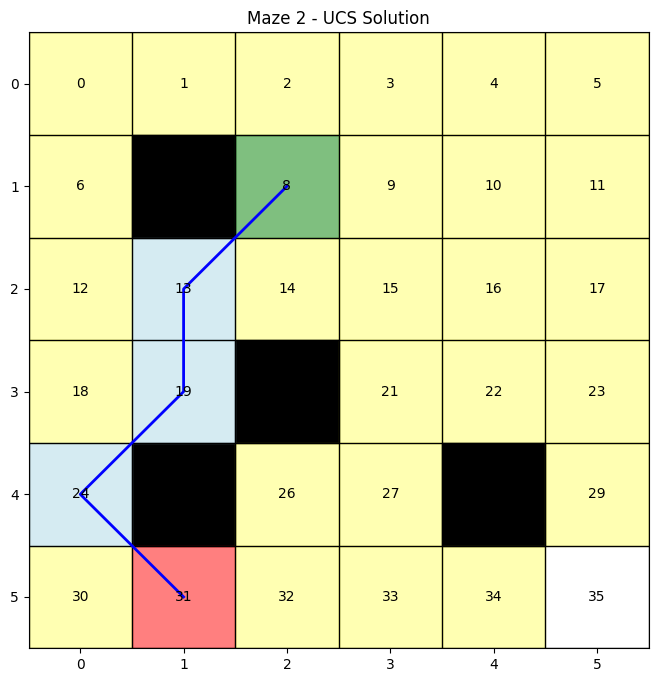


Running A* Search...
A* Path Found! Time: 11 minutes
Visited Nodes (11): [8, 14, 13, 15, 19, 21, 18, 24, 26, 9, 31]
Path (5): [8, 14, 19, 24, 31]


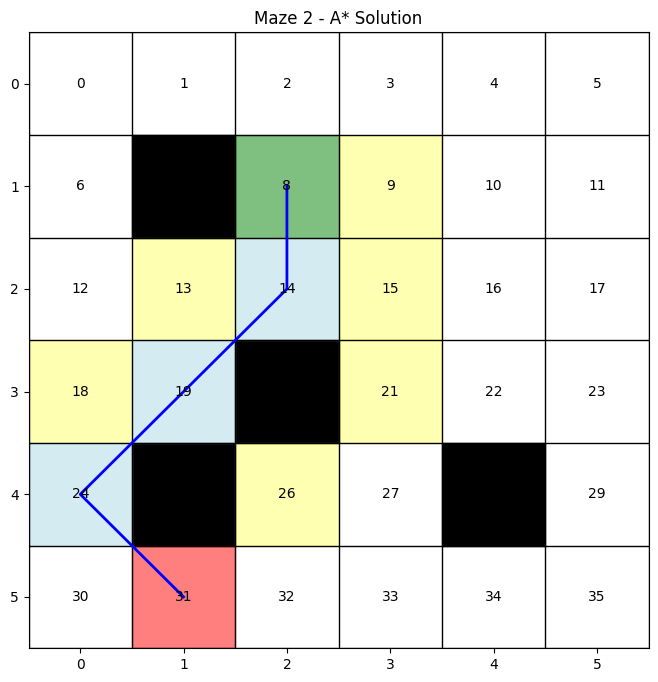


--- Maze 3 ---
Start Node: 1 at (1, 0)
Goal Node: 31 at (1, 5)
Barrier Nodes: [18, 28, 3, 15]


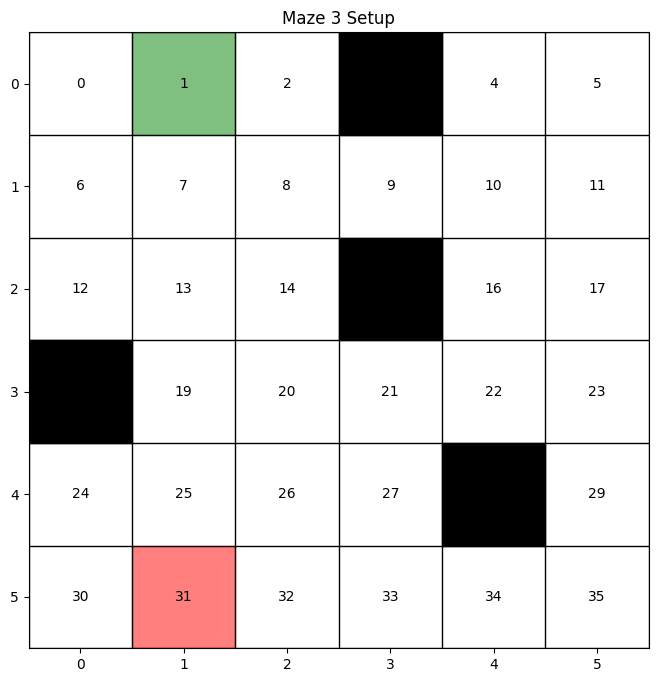


Running Uniform Cost Search...
UCS Path Found! Time: 25 minutes
Visited Nodes (25): [1, 0, 2, 7, 6, 8, 13, 9, 12, 14, 19, 10, 20, 4, 16, 21, 25, 11, 24, 26, 5, 17, 22, 27, 31]
Path (6): [1, 7, 13, 19, 25, 31]


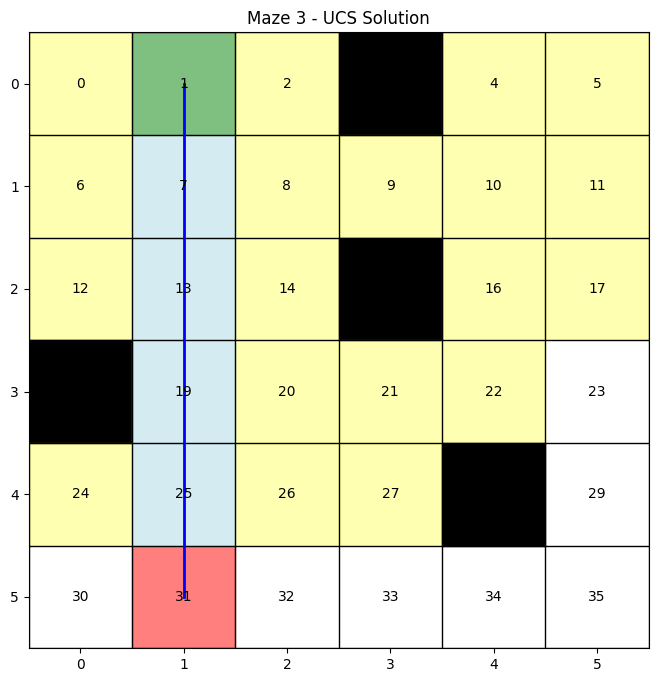


Running A* Search...
A* Path Found! Time: 6 minutes
Visited Nodes (6): [1, 7, 13, 19, 25, 31]
Path (6): [1, 7, 13, 19, 25, 31]


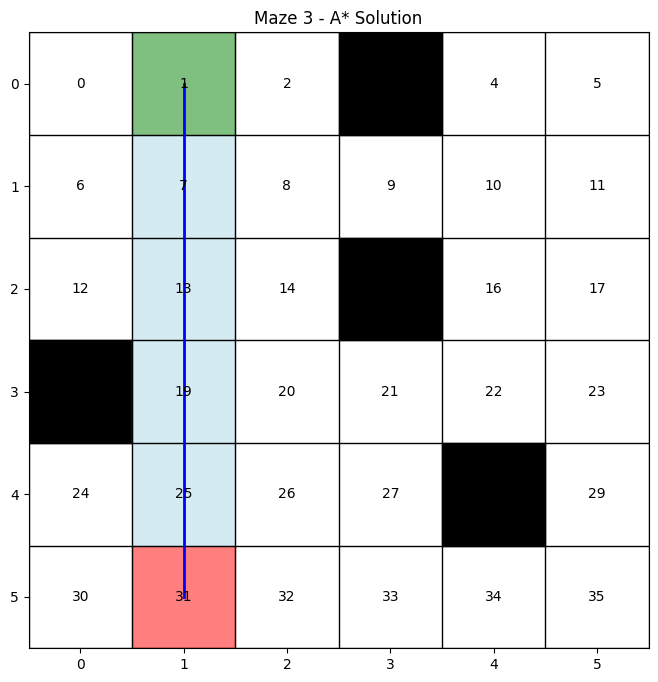


--- Analysis ---

Statistical Results:
+-----------+---------------------+-------------------+-------------------+----------------------+
| Algorithm | Mean Time (minutes) |   Time Variance   | Mean Path Length  | Path Length Variance |
+-----------+---------------------+-------------------+-------------------+----------------------+
|    UCS    | 28.333333333333332  | 6.222222222222222 | 5.333333333333333 | 0.22222222222222224  |
|    A*     |  8.666666666666666  | 4.222222222222222 | 5.333333333333333 | 0.22222222222222224  |
+-----------+---------------------+-------------------+-------------------+----------------------+


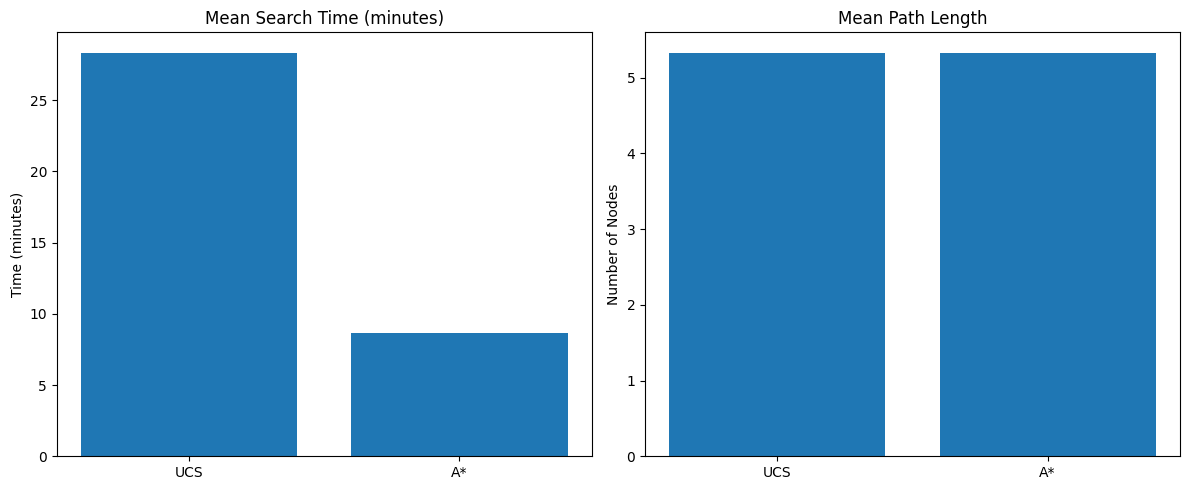


Analysis Summary:
1. Completeness: Both algorithms are complete and will find a path if one exists.
2. Optimality: Both UCS and A* are optimal, meaning they find the shortest path.
3. Time Complexity:
   - A* is more efficient and explores fewer nodes than UCS.


In [ ]:
# Task 05

def run_experiment(num_mazes=3):
    """
    Run the search algorithms on multiple random mazes and analyze results.

    Args:
        num_mazes: Number of random mazes to generate and test (default: 3)

    Returns:
        results: Dictionary containing raw results data
        stats: Dictionary containing statistical analysis of results
    """
    # Data collection dictionary to store results
    results = {
        'UCS': {'times': [], 'path_lengths': []},  # Store UCS results
        'A*': {'times': [], 'path_lengths': []}    # Store A* results
    }

    # Run experiments on multiple mazes
    for i in range(num_mazes):
        print(f"\n--- Maze {i+1} ---")

        # Create and setup a new random maze
        maze = Maze()
        start, goal, barriers = maze.setup_random_maze()

        # Print maze configuration
        print(f"Start Node: {start.node_id} at ({start.x}, {start.y})")
        print(f"Goal Node: {goal.node_id} at ({goal.x}, {goal.y})")
        print(f"Barrier Nodes: {[b.node_id for b in barriers]}")

        # Visualize initial maze
        maze.visualize(title=f"Maze {i+1} Setup")

        # ----- Uniform Cost Search -----
        print("\nRunning Uniform Cost Search...")
        ucs_visited, ucs_time, ucs_path = uniform_cost_search(maze)

        # Process UCS results
        if ucs_path:
            # Print search results
            print(f"UCS Path Found! Time: {ucs_time} minutes")
            print(f"Visited Nodes ({len(ucs_visited)}): {[n.node_id for n in ucs_visited]}")
            print(f"Path ({len(ucs_path)}): {[n.node_id for n in ucs_path]}")

            # Visualize UCS results
            maze.visualize(ucs_visited, ucs_path, f"Maze {i+1} - UCS Solution")

            # Store results for analysis
            results['UCS']['times'].append(ucs_time)
            results['UCS']['path_lengths'].append(len(ucs_path))
        else:
            print("UCS: No path found!")

        # ----- A* Search -----
        print("\nRunning A* Search...")
        astar_visited, astar_time, astar_path = a_star_search(maze)

        # Process A* results
        if astar_path:
            # Print search results
            print(f"A* Path Found! Time: {astar_time} minutes")
            print(f"Visited Nodes ({len(astar_visited)}): {[n.node_id for n in astar_visited]}")
            print(f"Path ({len(astar_path)}): {[n.node_id for n in astar_path]}")

            # Visualize A* results
            maze.visualize(astar_visited, astar_path, f"Maze {i+1} - A* Solution")

            # Store results for analysis
            results['A*']['times'].append(astar_time)
            results['A*']['path_lengths'].append(len(astar_path))
        else:
            print("A*: No path found!")

    # ----- Analysis of results -----
    print("\n--- Analysis ---")

    # Calculate statistics (mean and variance) for each algorithm
    stats = {}
    for algo in ['UCS', 'A*']:
        stats[algo] = {
            'time_mean': np.mean(results[algo]['times']),  # Average time
            'time_variance': np.var(results[algo]['times']),  # Variance in time
            'path_mean': np.mean(results[algo]['path_lengths']),  # Average path length
            'path_variance': np.var(results[algo]['path_lengths'])  # Variance in path length
        }

    # Create a comparison table using pandas DataFrame
    df = pd.DataFrame({
        'Algorithm': ['UCS', 'A*'],
        'Mean Time (minutes)': [stats['UCS']['time_mean'], stats['A*']['time_mean']],
        'Time Variance': [stats['UCS']['time_variance'], stats['A*']['time_variance']],
        'Mean Path Length': [stats['UCS']['path_mean'], stats['A*']['path_mean']],
        'Path Length Variance': [stats['UCS']['path_variance'], stats['A*']['path_variance']]
    })

    # Print statistical results as a nicely formatted table
    print("\nStatistical Results:")
    print(tabulate.tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

    # ----- Create comparison plots -----
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of plots

    # Time comparison plot (left plot)
    ax1.bar(['UCS', 'A*'],
           [stats['UCS']['time_mean'], stats['A*']['time_mean']])  # Heights (means)
           #yerr=[np.sqrt(stats['UCS']['time_variance']),
                 #np.sqrt(stats['A*']['time_variance'])])  # Error bars (std dev)
    ax1.set_title('Mean Search Time (minutes)')
    ax1.set_ylabel('Time (minutes)')

    # Path length comparison plot (right plot)
    ax2.bar(['UCS', 'A*'],
           [stats['UCS']['path_mean'], stats['A*']['path_mean']])  # Heights (means)
           #yerr=[np.sqrt(stats['UCS']['path_variance']),
                 #np.sqrt(stats['A*']['path_variance'])])  # Error bars (std dev)
    ax2.set_title('Mean Path Length')
    ax2.set_ylabel('Number of Nodes')

    # Adjust layout and display plots
    plt.tight_layout()
    plt.show()

    # ----- Print analysis conclusion -----
    print("\nAnalysis Summary:")
    print("1. Completeness: Both algorithms are complete and will find a path if one exists.")
    print("2. Optimality: Both UCS and A* are optimal, meaning they find the shortest path.")
    print("3. Time Complexity:")

    # Compare algorithm efficiency based on results
    if stats['UCS']['time_mean'] > stats['A*']['time_mean']:
        print("   - A* is more efficient and explores fewer nodes than UCS.")
    elif stats['UCS']['time_mean'] < stats['A*']['time_mean']:
        print("   - UCS is more efficient in these specific maze configurations.")
    else:
        print("   - Both algorithms have similar efficiency in these maze configurations.")

    # Return both raw results and computed statistics
    return results, stats

# Run the experiment when script is executed directly
if __name__ == "__main__":
    print("Six-by-Six Maze Search Algorithms: UCS and A*")
    print("=" * 50)

    # Run the experiment with 3 random mazes
    results, stats = run_experiment(num_mazes=3)